In [17]:
"""
Lookup‑Table Optimization on Arbitrary CSV (No synthetic function)
==================================================================

What this script provides
-------------------------
- **Input**: a CSV where **all columns except the last** are numeric features (d dims), and the **last column** is the objective (yield).
- **Domain**: the CSV rows themselves are the **finite candidate set**. No fitted surrogate oracle for the true function; the table is the ground truth.
- **Methods** (sequential over the table):
  1) **Random**: pick unseen rows uniformly at random.
  2) **Baseline BO (EI)**: fit a GP **only on the already‑revealed rows**, score **EI on the remaining rows**, choose the best.
  3) **Hybrid (prior + residual GP)**: like Baseline BO but allows a (flat by default) **prior mean** shaped by a JSON readout (LLM optional). Uses a residual GP over the prior.

New: Repetitions & Plotting
---------------------------
- Each main method now accepts a **`repeats`** parameter. Runs are repeated with seeds `seed, seed+1, ..., seed+repeats-1`.
- Use `compare_methods_from_csv(..., repeats=k)` to run all methods across `k` seeds.
- `plot_runs_mean_lookup(...)` plots **mean best‑so‑far** with a shaded uncertainty band across seeds.

Usage (Jupyter)
----------------
```python
# 1) Load the CSV
lt = load_lookup_csv("my_experiment_data.csv", impute_features="median")

# 2) Compare methods across 5 seeds and plot
hist = compare_methods_from_csv(lt, n_init=6, n_iter=25, seed=0, repeats=5,
                                include_hybrid=True, readout_source="flat")
plot_runs_mean_lookup(hist, ci="sem")  # or ci="sd" or "95ci"
```

Dependencies
------------
- torch >= 1.11, botorch, gpytorch, numpy, pandas, matplotlib
"""
import warnings
warnings.filterwarnings('ignore')

from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, Any, List, Optional, Tuple

import os, json
import numpy as np
import pandas as pd

import torch
from torch import Tensor

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.analytic import ExpectedImprovement

import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood

import matplotlib.pyplot as plt

# Optional LLM client (only used if readout_source="llm")
try:
    import httpx
    from openai import OpenAI
    _OPENAI_CLIENT = OpenAI(http_client=httpx.Client(verify=False))
except Exception:
    _OPENAI_CLIENT = None

# -------------------- Device / dtype --------------------
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DTYPE = torch.float32
torch.set_default_dtype(DTYPE)

# -------------------- Prior / residual machinery --------------------
from prior_gp import alignment_on_obs, fit_residual_gp, GPWithPriorMean, Prior
from readout_schema import readout_to_prior, flat_readout

# (Prompts are optional; only used if readout_source="llm")

from bo_readout_prompts import SYS_PROMPTS_PERFECT, SYS_PROMPTS_GOOD, SYS_PROMPTS_MEDIUM, SYS_PROMPTS_RANDOM, SYS_PROMPT_MINIMAL_HUMAN

SYS_PROMPTS  = SYS_PROMPT_MINIMAL_HUMAN
# ====================================================================
#                             DATASET LOADER
# ====================================================================

@dataclass
class LookupTable:
    X_raw: Tensor          # (N, d) raw (unnormalized) features
    y: Tensor              # (N,) objective (float)
    X: Tensor              # (N, d) normalized to [0,1]
    mins: Tensor           # (d,)
    maxs: Tensor           # (d,)
    feature_names: List[str]
    objective_name: str

    @property
    def n(self) -> int:
        return int(self.X.shape[0])

    @property
    def d(self) -> int:
        return int(self.X.shape[1])


def load_lookup_csv(path: str,
                     *,
                     device: torch.device = DEVICE,
                     dtype: torch.dtype = DTYPE,
                     impute_features: Optional[str] = None  # None | 'median'
                     ) -> LookupTable:
    """Load a CSV as a finite candidate set.

    Assumptions
    -----------
    - All columns except the last are numeric features; the last column is the objective.
    - Rows may contain NaN/inf or non-numeric strings; we coerce to numeric and clean deterministically.

    Cleaning policy
    ---------------
    - We always DROP rows with invalid objective (NaN/inf).
    - For features:
        * impute_features == 'median' -> fill NaN/inf with column median (computed per feature).
        * impute_features is None     -> DROP rows where any feature is NaN/inf.
    """
    df = pd.read_csv(path)
    if df.shape[1] < 2:
        raise ValueError("CSV must have at least 2 columns (>=1 feature + 1 objective)")

    feat_cols = list(df.columns[:-1])
    obj_col = df.columns[-1]

    # Coerce to numeric and replace inf with NaN
    for c in feat_cols + [obj_col]:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df[feat_cols] = df[feat_cols].replace([np.inf, -np.inf], np.nan)
    df[obj_col] = df[obj_col].replace([np.inf, -np.inf], np.nan)

    # Always drop rows with invalid objective
    mask_y = df[obj_col].notna()

    if impute_features == 'median':
        med = df.loc[mask_y, feat_cols].median(numeric_only=True)
        df.loc[:, feat_cols] = df[feat_cols].fillna(med)
        mask_x = df[feat_cols].notna().all(axis=1)
    else:
        mask_x = df[feat_cols].notna().all(axis=1)

    mask = (mask_y & mask_x)
    df_clean = df.loc[mask].reset_index(drop=True)

    if df_clean.shape[0] < 2:
        raise ValueError("After cleaning, fewer than 2 valid rows remain. Please inspect your CSV or enable median imputation for features.")

    X_raw_np = df_clean[feat_cols].to_numpy(dtype=np.float64)
    y_np = df_clean[obj_col].to_numpy(dtype=np.float64)

    X_raw = torch.tensor(X_raw_np, dtype=dtype, device=device)
    y = torch.tensor(y_np, dtype=dtype, device=device).reshape(-1)

    mins = X_raw.min(dim=0).values
    maxs = X_raw.max(dim=0).values
    rng = (maxs - mins).clamp_min(1e-12)
    # X = (X_raw - mins) / rng
    

    return LookupTable(
        X_raw=X_raw, y=y, X=X_raw, mins=mins, maxs=maxs,
        feature_names=feat_cols, objective_name=str(obj_col)
    )

# ====================================================================
#                         HELPER UTILITIES
# ====================================================================

def select_initial_indices(n_total: int, n_init: int, seed: int) -> List[int]:
    g = torch.Generator(device='cpu')
    g.manual_seed(int(seed))
    perm = torch.randperm(n_total, generator=g).tolist()
    return perm[:max(1, min(n_init, n_total))]


def remaining_indices(n_total: int, seen: set[int]) -> List[int]:
    return [i for i in range(n_total) if i not in seen]


def as_records_row(idx: int, x_norm: Tensor, y: float, best: float, method: str, feature_names: List[str]) -> Dict[str, Any]:
    rec = {
        "iter": None,  # filled by caller
        "idx": int(idx),
        "y": float(y),
        "best_so_far": float(best),
        "method": method,
    }
    for j in range(x_norm.numel()):
        rec[f"x{j+1}"] = float(x_norm[j].item())
    return rec


def force_scalar_sigma(readout):
    ro = dict(readout)
    bumps = []
    for b in ro.get("bumps", []) or []:
        sig = b.get("sigma", 0.15)
        if isinstance(sig, (list, tuple)):
            # choose how to collapse; mean is a sane default
            sig = float(np.mean(sig))
        b = {**b, "sigma": float(sig)}
        bumps.append(b)
    ro["bumps"] = bumps
    return ro


from llm_si import ExperimentState, run_llm_scout_init

# ---------- Initialization helpers ----------

def _sobol_init_lookup(lookup, n_init: int, seed: int) -> List[int]:
    """
    Generate n_init Sobol points in [0,1]^d, map them to the RAW feature scale
    using lookup.mins/maxs, then snap each proposal to the nearest unseen
    candidate (Euclidean distance in RAW space). Ensures uniqueness across
    picks and diversifies across seeds via a fast_forward offset.
    """
    from torch.quasirandom import SobolEngine

    d, N = lookup.d, lookup.n
    if n_init <= 0:
        return []

    engine = SobolEngine(dimension=d, scramble=True, seed=int(seed))
    # Seed-dependent offset so repeats differ even with same n_init
    offset = (int(seed) % 10007) * 64
    if offset:
        engine.fast_forward(offset)

    props_unit = engine.draw(n_init).to(device=lookup.X.device, dtype=lookup.X.dtype)  # (n_init,d)

    # Map unit-box proposals to RAW feature scale: x_raw = mins + u * (maxs - mins)
    mins = lookup.mins.to(device=lookup.X.device, dtype=lookup.X.dtype)
    rng = (lookup.maxs - lookup.mins).to(device=lookup.X.device, dtype=lookup.X.dtype).clamp_min(1e-12)
    props_raw = mins + props_unit * rng

    remaining = set(range(N))
    chosen: List[int] = []
    for k in range(n_init):
        x_prop = props_raw[k:k+1]  # (1,d) RAW
        # compute distances ONLY over remaining
        rem_idx = torch.tensor(sorted(list(remaining)), device=lookup.X.device, dtype=torch.long)
        cand = lookup.X.index_select(0, rem_idx)  # RAW
        j = int(torch.argmin(torch.linalg.norm(cand - x_prop, dim=1)).item())
        idx = int(rem_idx[j].item())
        chosen.append(idx)
        remaining.remove(idx)

    return chosen

def _llm_si_init_lookup(lookup, n_init: int) -> List[int]:
    """
    Run LLM-SI on the discrete table (normalized space). Returns used indices.
    """
    all_idx = list(range(lookup.n))
    state = ExperimentState(
        X_obs=torch.empty((0, lookup.d), device=lookup.X.device, dtype=lookup.X.dtype),
        y_obs=torch.empty((0,), device=lookup.X.device, dtype=lookup.X.dtype),
        log=[],
        bounds=None,                          # we are in lookup mode
        candidate_pool=lookup.X,              # normalized features
        candidate_y=lookup.y,                 # ground-truth objective
        remaining_idx=all_idx.copy(),         # start with all available
    )
    # Run the scouting phase for n_init picks
    state = run_llm_scout_init(state, n_scout=int(n_init))
    # The used indices are simply what's not remaining
    used = sorted(set(all_idx) - set(state.remaining_idx))
    return used


def _build_initial_from_indices(lookup, idxs: List[int], method_tag: str) -> tuple[set[int], torch.Tensor, torch.Tensor, list]:
    """
    Given a list of selected indices, build seen set, X_obs, Y_obs and
    the initial records with negative iteration ids (matching your existing convention).
    """
    seen = set(int(i) for i in idxs)
    X_obs = lookup.X[idxs]
    Y_obs = lookup.y[idxs]
    rec = []
    best_running = float('-inf')
    for i, idx in enumerate(idxs):
        y_i = float(lookup.y[idx].item())
        best_running = max(best_running, y_i)
        row = as_records_row(idx, lookup.X[idx], y_i, best_running, method=method_tag, feature_names=lookup.feature_names)
        row["iter"] = i - len(idxs)
        rec.append(row)
    return seen, X_obs, Y_obs, rec

# ====================================================================
#                     SUMMARIES FOR (OPTIONAL) LLM READOUT
# ====================================================================

def summarize_on_pool_for_llm(gp: SingleTaskGP, X_obs: Tensor, Y_obs: Tensor, X_pool: Tensor, topk: int = 12) -> Dict[str, Any]:
    """Summarize model state on a discrete pool for prompting.
    Handles Y_obs shaped (n,) or (n,1). Returns top EI / top variance points and incumbent.
    """
    with torch.no_grad():
        Y_flat = Y_obs.squeeze(-1) if Y_obs.dim() == 2 else Y_obs
        best_f = float(Y_flat.max().item())
        EI = ExpectedImprovement(model=gp, best_f=best_f, maximize=True)
        ei_vals = EI(X_pool.unsqueeze(1)).reshape(-1)
        post = gp.posterior(X_pool.unsqueeze(1))
        var = post.variance.reshape(-1)

        k = int(min(topk, X_pool.shape[0])) if X_pool.shape[0] > 0 else 0
        idx_ei = torch.topk(ei_vals, k=k).indices if k > 0 else torch.tensor([], dtype=torch.long)
        idx_var = torch.topk(var, k=k).indices if k > 0 else torch.tensor([], dtype=torch.long)

        def pack(idx):
            out = []
            for i in idx:
                xi = X_pool[int(i)].detach().cpu().tolist()
                out.append({"x": [float(v) for v in xi], "score": float(ei_vals[int(i)].item())})
            return out

        inc_i = int(torch.argmax(Y_flat))
        inc = {"x": X_obs[inc_i].detach().cpu().tolist(), "y": float(Y_flat[inc_i].item())}

        return {"best_so_far": best_f, "incumbent": inc,
                "top_ei": pack(idx_ei),
                "top_var": [{"x": X_pool[int(i)].detach().cpu().tolist(), "var": float(var[int(i)].item())} for i in idx_var],}

# ---- Readout dimension sanitizer ----------------------------------

def _coerce_list_len(vals, d, fill=0.5):
    if isinstance(vals, (int, float)):
        vals = [float(vals)]
    vals = list(vals)
    if len(vals) >= d:
        return [float(v) for v in vals[:d]]
    else:
        return [float(v) for v in (vals + [fill] * (d - len(vals)))]


def sanitize_readout_dim(readout: Dict[str, Any], d: int) -> Dict[str, Any]:
    """Coerce readout JSON to match feature dimension d.
    - Bumps: pad/truncate mu to length d; sigma scalar ok or list padded/truncated to d; keep amp as float.
    - Effects: keep only keys x1..xd.
    - Interactions: drop entries that refer to out-of-range dims when integer indices are provided.
    """
    if readout is None:
        return {"effects": {}, "interactions": [], "bumps": []}
    ro = {**readout}

    # bumps
    bumps_in = ro.get("bumps", []) or []
    bumps_out = []
    for b in bumps_in:
        try:
            mu = _coerce_list_len(b.get("mu", [0.5] * d), d, fill=0.5)
            sigma = b.get("sigma", 0.15)
            if isinstance(sigma, (list, tuple)):
                sigma = _coerce_list_len(sigma, d, fill=(sigma[-1] if len(sigma) else 0.15))
            amp = float(b.get("amp", 0.1))
            bumps_out.append({"mu": mu, "sigma": sigma, "amp": amp})
        except Exception:
            continue
    ro["bumps"] = bumps_out

    # effects: keep only x1..xd
    eff_in = ro.get("effects", {}) or {}
    eff_out = {}
    for k, v in eff_in.items():
        if isinstance(k, str) and k.startswith("x"):
            try:
                j = int(k[1:])
                if 1 <= j <= d:
                    eff_out[k] = v
            except Exception:
                pass
    ro["effects"] = eff_out

    # interactions: conservative filter
    inter_in = ro.get("interactions", []) or []
    inter_out = []
    for it in inter_in:
        keep = True
        pair = it.get("pair") or it.get("vars") or it.get("indices")
        if isinstance(pair, (list, tuple)) and len(pair) == 2:
            a, b = pair
            if (isinstance(a, int) and a > d) or (isinstance(b, int) and b > d):
                keep = False
        if keep:
            inter_out.append(it)
    ro["interactions"] = inter_out
    return ro

# -------------------- Prompt + LLM readout -------------------------

def llm_generate_readout(history_df: Optional[pd.DataFrame], gp_ctx: SingleTaskGP, X_obs: Tensor, Y_obs: Tensor,
                          X_pool: Tensor, sys_prompt: str = SYS_PROMPTS,
                          temperature: float = 0.2, model: str = "gpt-4o-mini") -> Dict[str, Any]:
    if _OPENAI_CLIENT is None:
        return {"effects": {}, "interactions": [], "bumps": []}  # fallback: flat
    ctx = summarize_on_pool_for_llm(gp_ctx, X_obs, Y_obs, X_pool)
    recent = history_df.tail(30).to_dict(orient="records") if (history_df is not None and not history_df.empty) else []

    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": json.dumps({"context": ctx, "recent": recent})},
    ]
    resp = _OPENAI_CLIENT.chat.completions.create(
        model=model, temperature=temperature, response_format={"type": "json_object"}, messages=messages,
    )
    
    try:
        return json.loads(resp.choices[0].message.content)
    except Exception:
        return {"effects": {}, "interactions": [], "bumps": []}

# ====================================================================
#                        CORE METHODS ON LOOKUP TABLE (single run)
# ====================================================================

def _run_random_lookup_single(lookup: LookupTable, *, n_init: int, n_iter: int, seed: int = 0) -> pd.DataFrame:
    N = lookup.n
    seen: set[int] = set(select_initial_indices(N, n_init, seed))

    idxs = list(seen)
    X_obs = lookup.X[idxs]
    Y_obs = lookup.y[idxs]

    rec: List[Dict[str, Any]] = []
    best_running = float('-inf')
    for i, idx in enumerate(idxs):
        y_i = float(lookup.y[idx].item())
        best_running = max(best_running, y_i)
        row = as_records_row(idx, lookup.X[idx], y_i, best_running, method="random", feature_names=lookup.feature_names)
        row["iter"] = i - len(idxs)
        rec.append(row)

    g = torch.Generator(device='cpu'); g.manual_seed(int(seed) + 12345)
    best = best_running
    for t in range(n_iter):
        rem = remaining_indices(N, seen)
        if not rem: break
        pick = rem[torch.randint(low=0, high=len(rem), size=(1,), generator=g).item()]
        seen.add(pick)

        y = float(lookup.y[pick].item())
        best = max(best, y)
        row = as_records_row(pick, lookup.X[pick], y, best, method="random", feature_names=lookup.feature_names)
        row["iter"] = t
        rec.append(row)

    df = pd.DataFrame(rec)
    return df


def _run_baseline_ei_lookup_single(lookup: LookupTable, *, n_init: int, n_iter: int, seed: int = 0,
                                   init_method: str = "random") -> pd.DataFrame:
    N = lookup.n

    # --- choose initial indices based on init_method ---
    init_method = init_method.lower()
    if init_method in ("random", "uniform"):
        idxs = select_initial_indices(N, n_init, seed)
    elif init_method in ("sobol", "sobo"):
        idxs = _sobol_init_lookup(lookup, n_init, seed)
    elif init_method in ("llm-si", "llm_si", "llmsi"):
        idxs = _llm_si_init_lookup(lookup, n_init)
    else:
        raise ValueError(f"Unknown init_method: {init_method}")

    # Build starting state & records
    seen, X_obs, Y_obs, rec = _build_initial_from_indices(lookup, idxs, method_tag="baseline_ei")

    # --- BO loop unchanged below ---
    best_running = float(max([r["y"] for r in rec]) if rec else -float("inf"))
    for t in range(n_iter):
        Y_obs2 = Y_obs.unsqueeze(-1)
        gp = SingleTaskGP(X_obs, Y_obs2)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        rem = remaining_indices(N, seen)
        if not rem: break
        X_pool = lookup.X[rem]
        with torch.no_grad():
            best_f = float(Y_obs.max().item())
            EI = ExpectedImprovement(model=gp, best_f=best_f, maximize=True)
            ei_vals = EI(X_pool.unsqueeze(1)).reshape(-1)
            idx_local = int(torch.argmax(ei_vals))
            pick = rem[idx_local]

        seen.add(pick)
        y = float(lookup.y[pick].item())
        best_running = max(best_running, y)
        X_obs = torch.cat([X_obs, lookup.X[pick].unsqueeze(0)], dim=0)
        Y_obs = torch.cat([Y_obs, torch.tensor([y], dtype=DTYPE, device=DEVICE)], dim=0)

        row = as_records_row(pick, lookup.X[pick], y, best_running, method="baseline_ei", feature_names=lookup.feature_names)
        row["iter"] = t
        rec.append(row)

    return pd.DataFrame(rec)

def _run_hybrid_lookup_single(lookup: LookupTable, *, n_init: int, n_iter: int, seed: int = 0,
                              init_method: str = "random",
                              readout_source: str = "flat",  # "flat" | "llm"
                              pool_base: Optional[int] = None,
                              debug_llm: bool = False,
                              model: str = "gpt-4o-mini",
                              log_json_path: Optional[str] = None) -> pd.DataFrame:
    N = lookup.n

    # --- choose initial indices based on init_method ---
    init_method_l = init_method.lower()
    if init_method_l in ("random", "uniform"):
        idxs = select_initial_indices(N, n_init, seed)
    elif init_method_l in ("sobol", "sobo"):
        idxs = _sobol_init_lookup(lookup, n_init, seed)
    elif init_method_l in ("llm-si", "llm_si", "llmsi"):
        idxs = _llm_si_init_lookup(lookup, n_init)
    else:
        raise ValueError(f"Unknown init_method: {init_method}")

    # Build starting state & records
    seen, X_obs, Y_obs, rec = _build_initial_from_indices(lookup, idxs, method_tag="hybrid")

    # --- prior selection as before ---
    if readout_source == "llm":
        Y_obs2 = Y_obs.unsqueeze(-1)
        gp_ctx = SingleTaskGP(X_obs, Y_obs2)
        mll = ExactMarginalLogLikelihood(gp_ctx.likelihood, gp_ctx)
        fit_gpytorch_mll(mll)
        rem0 = remaining_indices(N, seen)
        X_pool0 = lookup.X[rem0] if rem0 else torch.empty((0, lookup.d), device=DEVICE, dtype=DTYPE)
        ro0_raw = llm_generate_readout(pd.DataFrame(rec), gp_ctx, X_obs, Y_obs2, X_pool0, model=model)
        ro0_raw = force_scalar_sigma(sanitize_readout_dim(ro0_raw, lookup.d))
        ro0 = sanitize_readout_dim(ro0_raw, lookup.d)
    else:
        ro0 = flat_readout()
    prior = readout_to_prior(ro0)
    m0_w = 1.0

    status_log: List[Dict[str, Any]] = []
    if log_json_path is not None and readout_source == "llm":
        status_log.append({"iter": -1, "readout": ro0})

    best_running = float(max([r["y"] for r in rec]) if rec else -float("inf"))

    for t in range(n_iter):
        Y_obs2 = Y_obs.unsqueeze(-1)
        gp_resid, alpha = fit_residual_gp(X_obs, Y_obs2, prior)
        rho = alignment_on_obs(X_obs, Y_obs2, prior)
        model_total = GPWithPriorMean(gp_resid, prior, m0_scale=float(alpha * m0_w))
        EI = ExpectedImprovement(model=model_total, best_f=float(Y_obs.max().item()), maximize=True)

        rem = remaining_indices(N, seen)
        if not rem: break
        if pool_base is not None and len(rem) > pool_base:
            g = torch.Generator(device='cpu'); g.manual_seed(int(seed) + 777 + t)
            idx_sub = torch.tensor(rem)[torch.randperm(len(rem), generator=g)[:pool_base]].tolist()
            rem_eval = idx_sub
        else:
            rem_eval = rem
        X_pool = lookup.X[rem_eval]

        if readout_source == "llm":
            gp_ctx = SingleTaskGP(X_obs, Y_obs2)
            mll = ExactMarginalLogLikelihood(gp_ctx.likelihood, gp_ctx)
            fit_gpytorch_mll(mll)
            ro_t_raw = llm_generate_readout(pd.DataFrame(rec), gp_ctx, X_obs, Y_obs2, X_pool, model=model)
            ro_t_raw = force_scalar_sigma(sanitize_readout_dim(ro_t_raw, lookup.d))
            ro_t = sanitize_readout_dim(ro_t_raw, lookup.d)
            prior = readout_to_prior(ro_t)
            if log_json_path is not None:
                status_log.append({"iter": t, "readout": ro_t})

        with torch.no_grad():
            ei_vals = EI(X_pool.unsqueeze(1)).reshape(-1)
            idx_local = int(torch.argmax(ei_vals))
            pick = rem_eval[idx_local]

        y = float(lookup.y[pick].item())
        best_running = max(best_running, y)
        seen.add(pick)
        X_obs = torch.cat([X_obs, lookup.X[pick].unsqueeze(0)], dim=0)
        Y_obs = torch.cat([Y_obs, torch.tensor([y], dtype=DTYPE, device=DEVICE)], dim=0)

        row = as_records_row(pick, lookup.X[pick], y, best_running, method="hybrid", feature_names=lookup.feature_names)
        row["iter"] = t
        rec.append(row)

    if log_json_path is not None and readout_source == "llm":
        dirpath = os.path.dirname(log_json_path)
        if dirpath:
            os.makedirs(dirpath, exist_ok=True)
        with open(log_json_path, 'w') as f:
            json.dump(status_log, f, indent=2)

    return pd.DataFrame(rec)

# ====================================================================
#                        PUBLIC METHODS (with repeats)
# ====================================================================

def run_random_lookup(lookup: LookupTable, *, n_init: int, n_iter: int, seed: int = 0, repeats: int = 1) -> pd.DataFrame:
    """Random selection over the table. If repeats>1, runs multiple seeds and concatenates results."""
    if repeats <= 1:
        df = _run_random_lookup_single(lookup, n_init=n_init, n_iter=n_iter, seed=seed)
        df["seed"] = seed
        return df
    dfs = []
    for r in range(repeats):
        s = seed + r
        dfr = _run_random_lookup_single(lookup, n_init=n_init, n_iter=n_iter, seed=s)
        dfr["seed"] = s
        dfs.append(dfr)
    return pd.concat(dfs, ignore_index=True)


def run_baseline_ei_lookup(lookup: LookupTable, *, n_init: int, n_iter: int, seed: int = 0,
                           repeats: int = 1, init_method: str = "random") -> pd.DataFrame:
    if repeats <= 1:
        df = _run_baseline_ei_lookup_single(lookup, n_init=n_init, n_iter=n_iter, seed=seed,
                                            init_method=init_method)
        df["seed"] = seed
        return df
    dfs = []
    for r in range(repeats):
        s = seed + r
        dfr = _run_baseline_ei_lookup_single(lookup, n_init=n_init, n_iter=n_iter, seed=s,
                                             init_method=init_method)
        dfr["seed"] = s
        dfs.append(dfr)
    return pd.concat(dfs, ignore_index=True)


def run_hybrid_lookup(lookup: LookupTable, *, n_init: int, n_iter: int, seed: int = 0,
                      repeats: int = 1, init_method: str = "random",
                      readout_source: str = "flat", pool_base: Optional[int] = None,
                      debug_llm: bool = False, model: str = "gpt-4.1",
                      log_json_path: Optional[str] = None) -> pd.DataFrame:
    if repeats <= 1:
        df = _run_hybrid_lookup_single(lookup, n_init=n_init, n_iter=n_iter, seed=seed,
                                       init_method=init_method,
                                       readout_source=readout_source, pool_base=pool_base,
                                       debug_llm=debug_llm, model=model, log_json_path=log_json_path)
        df["seed"] = seed
        return df
    dfs = []
    for r in range(repeats):
        s = seed + r
        dfr = _run_hybrid_lookup_single(lookup, n_init=n_init, n_iter=n_iter, seed=s,
                                        init_method=init_method,
                                        readout_source=readout_source, pool_base=pool_base,
                                        debug_llm=debug_llm, model=model, log_json_path=None)
        dfr["seed"] = s
        dfs.append(dfr)
    return pd.concat(dfs, ignore_index=True)


def compare_methods_from_csv(lookup: LookupTable, n_init: int = 6, n_iter: int = 25, seed: int = 0,
                             repeats: int = 1, include_hybrid: bool = True, readout_source: str = "flat",
                             init_method: str = "random") -> pd.DataFrame:
    dfs: List[pd.DataFrame] = []
    rand = run_random_lookup(lookup, n_init=n_init, n_iter=n_iter, seed=seed, repeats=repeats)
    base = run_baseline_ei_lookup(lookup, n_init=n_init, n_iter=n_iter, seed=seed,
                                  repeats=repeats, init_method=init_method)
    dfs.extend([rand, base])
    if include_hybrid:
        hyb = run_hybrid_lookup(lookup, n_init=n_init, n_iter=n_iter, seed=seed, repeats=repeats,
                                init_method=init_method, readout_source=readout_source)
        dfs.append(hyb)
    return pd.concat(dfs, ignore_index=True)

# ====================================================================
#                          COMPARISON WRAPPER
# ====================================================================



# ====================================================================
#                              PLOTTING
# ====================================================================

def plot_runs_mean_lookup(hist_df: pd.DataFrame, *, methods: Optional[List[str]] = None,
                          ci: str = "sd", ax: Optional[plt.Axes] = None,
                          title: Optional[str] = None) -> plt.Axes:
    """Plot mean best-so-far vs iteration across seeds with a shaded uncertainty band.

    Args:
        hist_df: long-form DataFrame from compare_methods_from_csv (must contain columns: method, iter, best_so_far, seed).
        methods: subset of method names to plot (default: all in hist_df).
        ci: "sd" (±1 std), "sem" (±1 std/sqrt(n)), or "95ci" (±1.96*std/sqrt(n)).
        ax: optional matplotlib Axes.
        title: optional plot title.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7.5, 4.5))

    df = hist_df.copy()
    df = df[df["iter"] >= 0]  # plot only acquisition iterations

    if methods is None:
        methods = list(df["method"].unique())

    for m in methods:
        d = df[df["method"] == m]
        if d.empty:
            continue
        agg = d.groupby("iter")["best_so_far"].agg(["mean", "std", "count"]).reset_index()
        if ci == "sem":
            err = agg["std"] / np.maximum(agg["count"], 1).pow(0.5)
        elif ci == "95ci":
            err = 1.96 * agg["std"] / np.maximum(agg["count"], 1).pow(0.5)
        else:  # "sd"
            err = agg["std"]
        x = agg["iter"].to_numpy()
        y = agg["mean"].to_numpy()
        e = err.to_numpy()
        ax.plot(x, y, label=m)
        ax.fill_between(x, y - e, y + e, alpha=0.20)

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Best so far")
    if title:
        ax.set_title(title)
    ax.grid(True, alpha=0.35)
    ax.legend()
    plt.tight_layout()
    return ax


<Axes: xlabel='Iteration', ylabel='Best so far'>

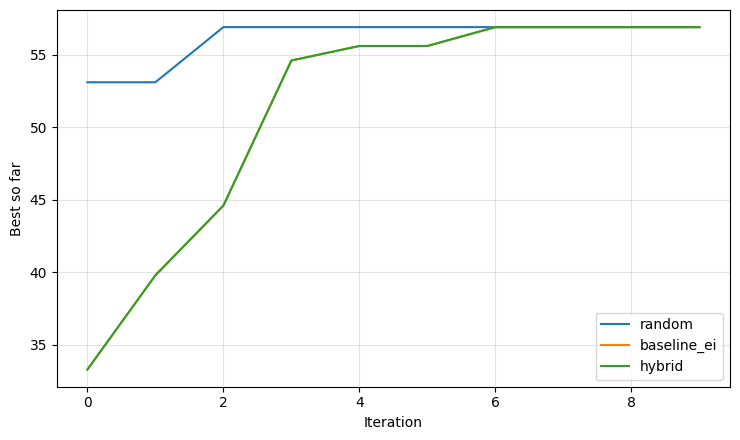

In [29]:
lt = load_lookup_csv("Aldol Condensation.csv", impute_features="median")
# LLM-SI init (deterministic GOAL_A..E scouting before BO)
hist = compare_methods_from_csv(lt, n_init=5, n_iter=10, seed=19, repeats=1,
                                init_method="llm-si", include_hybrid=True, readout_source="llm")
plot_runs_mean_lookup(hist)

In [30]:
hist

,iter,idx,y,best_so_far,method,x1,x2,x3,x4,seed
0,-5,98,52.700001,52.700001,random,15.820000,0.20,32.0,14.4,19
1,-4,101,53.099998,53.099998,random,17.290001,0.20,61.0,6.9,19
2,-3,108,24.900000,53.099998,random,3.910000,0.20,39.0,7.4,19
3,-2,46,38.299999,53.099998,random,10.240000,0.19,31.0,6.4,19
4,-1,89,4.600000,53.099998,random,1.000000,0.20,64.0,5.5,19
5,0,25,17.400000,53.099998,random,3.220000,0.20,63.0,15.0,19
6,1,82,26.900000,53.099998,random,6.140000,0.19,30.0,7.2,19
7,2,59,56.900002,56.900002,random,13.510000,0.19,51.0,7.0,19
8,3,41,55.500000,56.900002,random,11.040000,0.19,44.0,11.8,19
9,4,17,39.200001,56.900002,random,9.460000,0.15,69.0,11.6,19


In [16]:
hist.to_csv("temp.csv")

<Axes: xlabel='Iteration', ylabel='Best so far'>

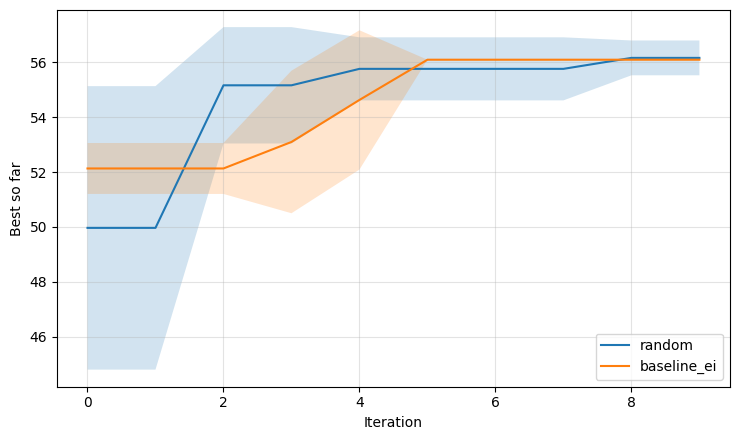

In [27]:
hist = compare_methods_from_csv(lt, n_init=5, n_iter=10, seed=19, repeats=3,
                                init_method="sobol", include_hybrid=False, readout_source="flat")
plot_runs_mean_lookup(hist)

In [9]:
hist

,iter,idx,y,best_so_far,method,x1,x2,x3,x4,seed
0,-5,0,5.400000,5.400000,random,1.270000,0.12,37.0,12.9,0
1,-4,67,56.400002,56.400002,random,16.750000,0.19,51.0,8.0,0
2,-3,68,47.799999,56.400002,random,10.310000,0.17,35.0,6.9,0
3,-2,120,53.099998,56.400002,random,13.650000,0.20,60.0,7.4,0
4,-1,88,3.200000,56.400002,random,1.000000,0.20,54.0,6.4,0
...,...,...,...,...,...,...,...,...,...,...
295,15,23,30.799999,56.099998,baseline_ei,25.120001,0.13,70.0,11.4,5
296,16,59,56.900002,56.900002,baseline_ei,13.510000,0.19,51.0,7.0,5
297,17,40,50.799999,56.900002,baseline_ei,43.570000,0.20,53.0,6.7,5
298,18,64,29.200001,56.900002,baseline_ei,40.400002,0.20,67.0,14.8,5


<Axes: xlabel='Iteration', ylabel='Best so far'>

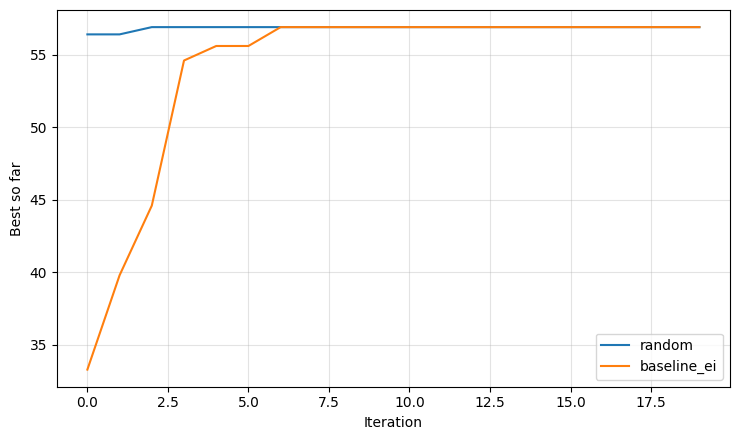

In [4]:
plot_runs_mean_lookup(hist)

baseline ei: iteration 0, y = 5.400000095367432, y_best = 54.70000076293945, X = 0
baseline ei: iteration 1, y = 3.299999952316284, y_best = 54.70000076293945, X = 1
baseline ei: iteration 2, y = 50.900001525878906, y_best = 54.70000076293945, X = 2
baseline ei: iteration 3, y = 0.0, y_best = 54.70000076293945, X = 3
baseline ei: iteration 4, y = 29.299999237060547, y_best = 54.70000076293945, X = 4
baseline ei: iteration 5, y = 56.099998474121094, y_best = 56.099998474121094, X = 5
baseline ei: iteration 6, y = 54.400001525878906, y_best = 56.099998474121094, X = 47
baseline ei: iteration 7, y = 44.099998474121094, y_best = 56.099998474121094, X = 70
baseline ei: iteration 8, y = 47.5, y_best = 56.099998474121094, X = 117
baseline ei: iteration 9, y = 0.0, y_best = 56.099998474121094, X = 86
baseline ei: iteration 10, y = 12.300000190734863, y_best = 56.099998474121094, X = 49
baseline ei: iteration 11, y = 5.0, y_best = 56.099998474121094, X = 43
baseline ei: iteration 12, y = 4.5999

<Axes: xlabel='Iteration', ylabel='Best so far'>

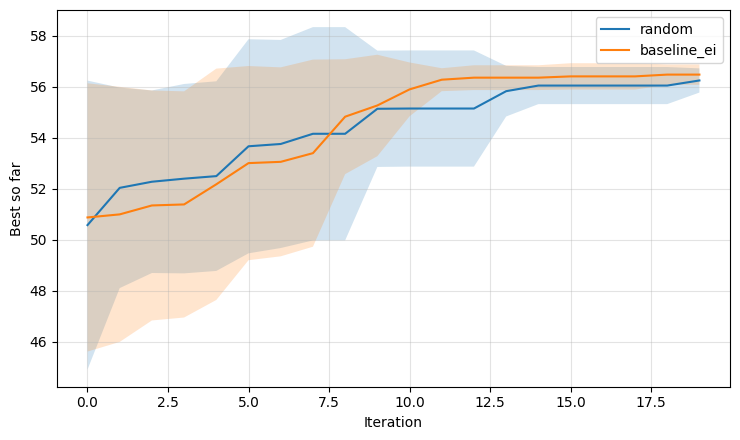

In [17]:
lt = load_lookup_csv("Aldol Condensation.csv")              # last col = objective
hist = compare_methods_from_csv(
    lt, n_init=3, n_iter=20, seed=43534, repeats=10,
    include_hybrid=False, readout_source="llm"  # or "llm"
)
hist.head()
plot_runs_mean_lookup(hist)

<Axes: xlabel='Iteration', ylabel='Best so far'>

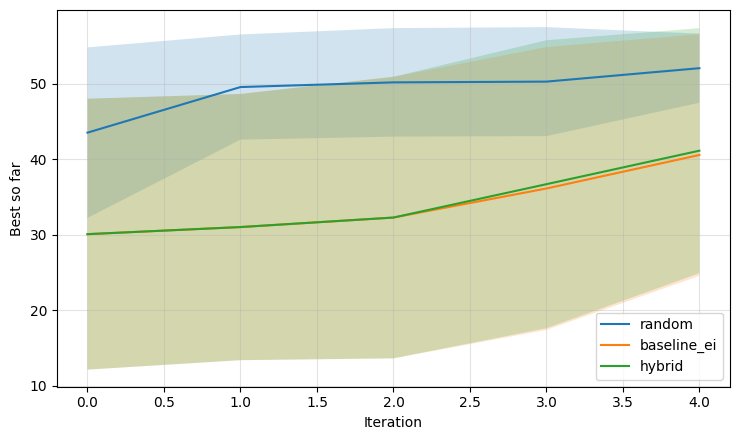

In [3]:
plot_runs_mean_lookup(hist)

In [14]:
hist.to_csv("res.csv")

<Axes: xlabel='Iteration', ylabel='Best so far'>

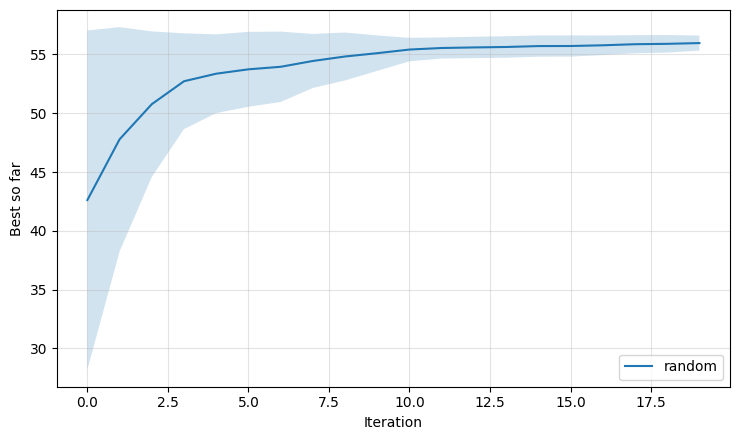

In [39]:
rand = run_random_lookup(lt, n_init=0, n_iter=20, seed=242, repeats=60)
plot_runs_mean_lookup(rand)

<Axes: xlabel='Iteration', ylabel='Best so far'>

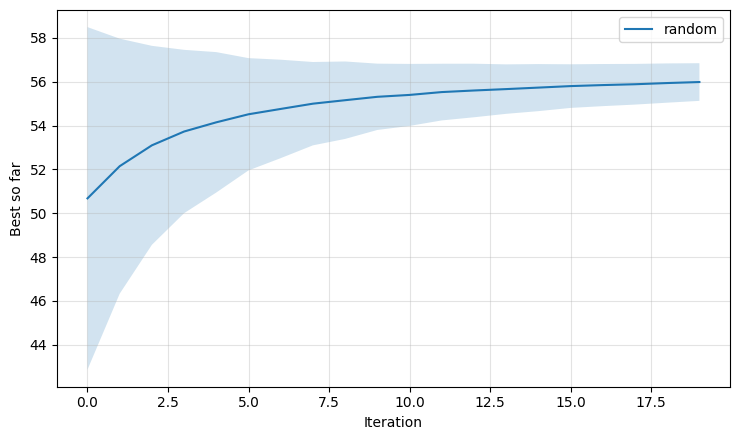

In [30]:
plot_runs_mean_lookup(rand)